In [1]:
from magma import *
import os
os.environ["MANTLE"] = "lattice"
from mantle.common import FFs

@cache_definition
def DefineShiftRegister(n, init=0, has_ce=False, has_reset=False):
    class _ShiftRegister(Circuit):
        name = 'ShiftRegister_{}_{}_{}_{}'.format(n, init, has_ce, has_reset)
        IO = ['I', In(Bit), 'O', Out(Bit)] + \
               ClockInterface(has_ce, has_reset)
        @classmethod
        def definition(siso):
            ffs = FFs(n, init=init, has_ce=has_ce, has_reset=has_reset)
            reg = braid(ffs, foldargs={"I":"O"})
            reg(siso.I)
            wire(reg.O, siso.O)
            wireclock(siso, reg)
    return _ShiftRegister

import mantle lattice ice40
import mantle lattice mantle40


In [2]:
from magma.backend.verilog import compile as compile_verilog
print(compile_verilog(DefineShiftRegister(2, has_ce=True)))

compiling ShiftRegister_2_0_True_False
module ShiftRegister_2_0_True_False (input  I, output  O, input  CLK, input  CE);
wire  inst0_Q;
wire  inst1_Q;
SB_DFFE inst0 (.C(CLK), .E(CE), .D(I), .Q(inst0_Q));
SB_DFFE inst1 (.C(CLK), .E(CE), .D(inst0_Q), .Q(inst1_Q));
assign O = inst1_Q;
endmodule




In [20]:
from magma.simulator import PythonSimulator
from magma.bit_vector import BitVector

N = 3
ShiftRegisterNCE = DefineShiftRegister(N, has_ce=True)
simulator = PythonSimulator(ShiftRegisterNCE, clock=ShiftRegisterNCE.CLK)
outputs = []
for j in range(2):
    simulator.step()
    simulator.evaluate()
for I, enable in [(1, 1), (0, 1), (1, 1), (0, 1), (1, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1)]:
    simulator.set_value(ShiftRegisterNCE.I, bool(I))
    simulator.set_value(ShiftRegisterNCE.CE, bool(enable))
    for j in range(2):
        simulator.step()
        simulator.evaluate()
        O = simulator.get_value(ShiftRegisterNCE.O)
        CLK = simulator.get_value(ShiftRegisterNCE.CLK)
        outputs.append([O, I, enable, CLK])

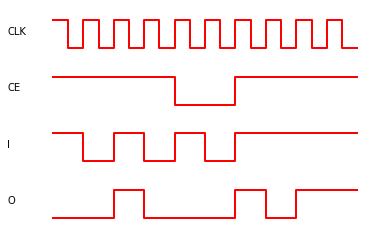

In [21]:
from magma.waveform import waveform

waveform(outputs, ["O", "I", "CE", "CLK"])